In [1]:
import torch, torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from time import time
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = './img/transfer_learning'

In [2]:
def train_and_validate(model, loss_criterion, optimizer, epochs=32):
    '''Trains and validates model
    Arguments:
    'model': Model to train and validate
    'loss_criterion' - loss Criterion to minimize
    'optimizer' - optimizer for computing gradients
    'epochs' - number of epochs
    Returns
    'model' - Trained Model with best validation accuracy
    'history' - avg train/valid loss, avg train/valid acc
    'best_epoch' - best epoch
    '''
    start = time()
    history: list = []
    best_loss: float = 100000
    best_epoch = None
    for epoch in range(epochs):
        epoch_start = time()
        # Training
        model.train()
        # Loss and Accuracy within the epoch
        train_loss: float = 0
        train_acc: float = 0
        valid_loss: float = 0
        valid_acc: float = 0
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
        # Validation
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                # Compute loss
                loss = loss_criterion(outputs, labels)
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time()
        print('Epoch : {:03d},  Time: {:.3f}s'.format(epoch, epoch_end-epoch_start))
        print('Training:    Loss - {:.4f}, Accuracy - {:.4f}%'.format(avg_train_loss, avg_train_acc*100)) 
        print('Validation : Loss - {:.4f}, Accuracy - {:.4f}%'.format(avg_valid_loss, avg_valid_acc*100)) 
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
    return model, history, best_epoch    

In [3]:
def predict(model, image_path):
    '''Predicts the class of an image
    Arguments:
    'model' - test model to test
    'image_path' - image path
    '''
    transform = image_transforms['test']
    image = Image.open(image_path)
    plt.imshow(image)
    image_tensor = transform(image)
    image_tensor = image_tensor.view(1, 3, 224, 224)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            label = idx_to_class[topclass.cpu().numpy()[0][i]]
            score = topk.cpu().numpy()[0][i]
            print("Predcition", i+1, ":", label, ", Score: ", score)

In [4]:
# Applying Transforms to the Data
filters = [
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip()] + filters        
    ),
    'valid': transforms.Compose(filters),
    'test': transforms.Compose(filters)
}

In [5]:
# Load the Data
# Set train and valid directory paths
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')
# Batch size
bs = 32
# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)
print(idx_to_class)

{0: 'bear', 1: 'camel', 2: 'dog', 3: 'dog_faces', 4: 'elk'}


In [6]:
# Load pretrained ResNet101 Model
resnet = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
resnet = resnet.to(device)

In [7]:
# Freeze model parameters
for param in resnet.parameters():
    param.requires_grad = False

In [8]:
# Change the final layer of ResNet101 Model for Transfer Learning
fc_inputs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.LogSoftmax(dim=1) 
)
# Convert model to be used on GPU
resnet = resnet.to(device)

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet.parameters())

In [10]:
num_epochs = 2
trained_model, history, best_epoch = train_and_validate(resnet, loss_func, optimizer, num_epochs)
torch.save(history, dataset+'_history.pt')

Epoch : 000,  Time: 90.874s
Training:    Loss - 1.1298, Accuracy - 55.2361%
Validation : Loss - 0.4524, Accuracy - 84.5996%
Epoch : 001,  Time: 75.363s
Training:    Loss - 0.4958, Accuracy - 81.1088%
Validation : Loss - 0.2318, Accuracy - 94.6612%


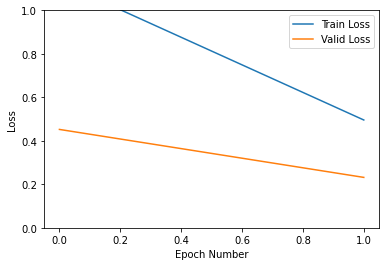

In [11]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

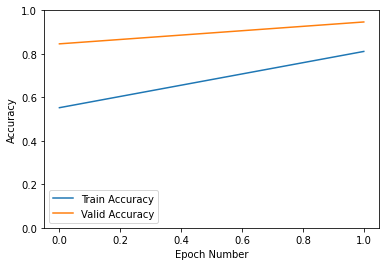

In [12]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

tensor([[-5.2201, -6.0714, -1.8923, -0.1771, -5.5506]], device='cuda:0')
tensor([[0.0054, 0.0023, 0.1507, 0.8377, 0.0039]], device='cuda:0')
Predcition 1 : dog_faces , Score:  0.8376821
Predcition 2 : dog , Score:  0.15071794
Predcition 3 : bear , Score:  0.0054066884


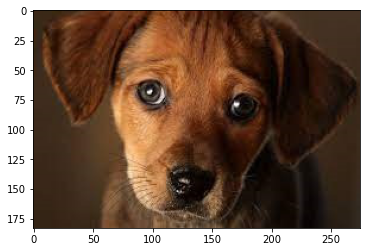

In [13]:
# Test a particular model on a test image
model = torch.load(f"{dataset}_model_{best_epoch}.pt")
predict(model, './img/pretrain/dog_face.jpg')       